# PHY 266 HW 9

In [2]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import glob
import emcee
import corner

from astropy.modeling import models, fitting
from matplotlib.patches import Ellipse
from math import pi
from scipy.fft import fft, ifft, rfft, irfft, fftfreq

## Prb 1. Displaying and describing a spectral line.

### 1 a)

In [3]:
data = np.loadtxt('../data/spectralline.txt')
wav = data[:, 0]
intensity = data[:, 1]

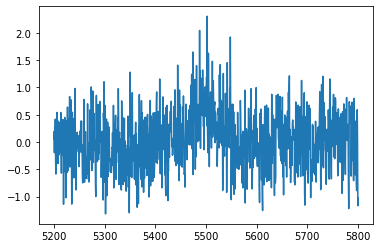

In [4]:
plt.plot(wav, intensity)

In [5]:
N = len(intensity)
rfft_int = rfft(intensity)
freq_int = fftfreq(N, 0.6)[:N//2]

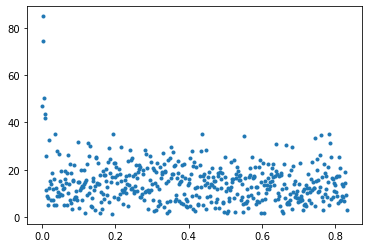

In [6]:
plt.plot(freq_int, np.abs(rfft_int)[:-1], '.')

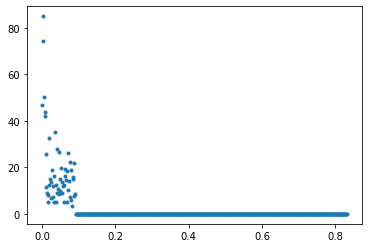

In [7]:
smooth_mask = freq_int < .09
smooth_fft = rfft_int[:-1] * smooth_mask
smooth_int = irfft(smooth_fft)
plt.plot(freq_int, np.abs(smooth_fft), '.')

Text(0.5, 1.0, 'Smoothed spectrum')

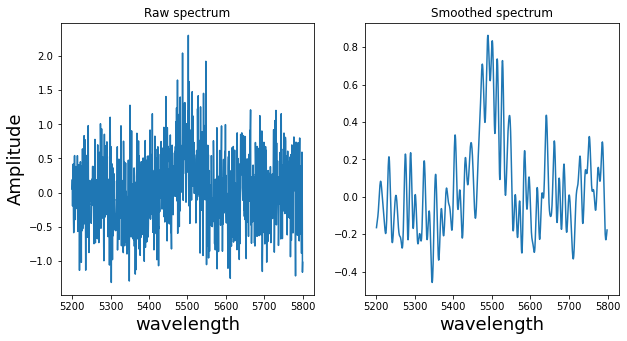

In [8]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(wav, intensity)
ax1.set_xlabel('wavelength', fontdict={'fontsize':18})
ax1.set_ylabel('Amplitude', fontdict={'fontsize':18})
ax1.set_title('Raw spectrum')

ax2 = fig.add_subplot(122)
ax2.plot(wav[1:-2], smooth_int)
ax2.set_xlabel('wavelength', fontdict={'fontsize':18})
#ax2.set_ylabel('Amplitude', fontdict={'fontsize':18})
ax2.set_title('Smoothed spectrum')

### 1 b) 

In [9]:
box_80_mask = (wav> 5420.0) & (wav < 5580.)  
box_80_wav = wav[box_80_mask]
box_80_int = intensity[box_80_mask]

box_100_mask = (wav> 5400.0) & (wav < 5600.)  
box_100_wav = wav[box_100_mask]
box_100_int = intensity[box_100_mask] 

box_120_mask = (wav> 5380.0) & (wav < 5620.) 
box_120_wav = wav[box_120_mask]
box_120_int = intensity[box_120_mask]

In [10]:
first_mom_80 = np.sum(box_80_wav * box_80_int) / np.sum(box_80_int)
second_mom_80 = np.sum((box_80_wav - first_mom_80)**2 * box_80_int) / np.sum(box_80_int)

first_mom_100 = np.sum(box_100_wav * box_100_int) / np.sum(box_100_int)
second_mom_100 = np.sum((box_100_wav - first_mom_100)**2 * box_100_int) / np.sum(box_100_int)

first_mom_120 = np.sum(box_120_wav * box_120_int) / np.sum(box_120_int)
second_mom_120 = np.sum((box_120_wav - first_mom_120)**2 * box_120_int) / np.sum(box_120_int)

In [11]:
print('\ncentral wavelength : %f  linewidth : %f' %(first_mom_80, np.sqrt(second_mom_80)))

print('\ncentral wavelength : %f  linewidth : %f' %(first_mom_100, np.sqrt(second_mom_100)))

print('\ncentral wavelength : %f  linewidth : %f' %(first_mom_120, np.sqrt(abs(second_mom_120))))



central wavelength : 5494.329626  linewidth : 17.956238

central wavelength : 5493.183398  linewidth : 29.778916

central wavelength : 5486.755588  linewidth : 17.022846


### From the moments we can conclude that this procedure is not stable as the moments changes a lot with the box size.

### 1 c) Assuming Gaussian profiles the true line width, $\sigma_{true}$, would be $$ \sigma_{true} = (\sigma_{obs}^2 - \sigma_{inst}^2)^{\frac{1}{2}}$$
###  In this method we are taking the differenec of the squares of two big numbers and than taking square root of the difference. From the propagation of error we can say that big uncertainty is related to this method.

## Prb 2. Practice with MCMC

### 2 a)

In [12]:
def log_likelihood(theta):
     
    amp, cent_wav, sigma = theta
    inst_sigma = 20     # instrumental sigma 
    obs_sigma = np.sqrt(sigma**2 + inst_sigma**2)  # observed sigma assuming gaussian profiles
     
    model = amp * np.exp(-(wav - cent_wav)**2 / (2 * obs_sigma**2))  # Gaussian model 
    
    log_lk = -0.5 * np.sum((intensity - model)**2 / 0.5**2)  # uncertaity in each pixel is 0.5 
    #print(log_lk)
    
    return log_lk


def prior_prob(sigma):
    
    if 0< sigma <= 30 :
        prob = 1.0 /30     # assuming uniform prior on true line width
        return np.log(prob)
    else:
        return -np.inf
    
    
def log_prob(theta):
    
    amp, cent_wav, sigma = theta
    
    l_prior = prior_prob(sigma)
    
    l_lk = log_likelihood(theta)
    
    if np.isfinite(l_prior):
        if np.isfinite(l_lk):
            return l_lk + l_prior
        else:
            return -np.inf
    else:
        return -np.inf

### 2 b)

In [14]:
nwalkers = 50
ndim = 3        # three parameters 
initial = np.random.rand(nwalkers*ndim).reshape((nwalkers,ndim))*0.01 + \
            np.tile(np.array([1.0, 5450.0, 1.0]), nwalkers).reshape((nwalkers, ndim)) # initial guess
#print(mu_initial)

sampler= emcee.EnsembleSampler(nwalkers, ndim, log_prob)

pos, prob, state = sampler.run_mcmc(initial, 5000)

Text(0.5, 0, 'step number')

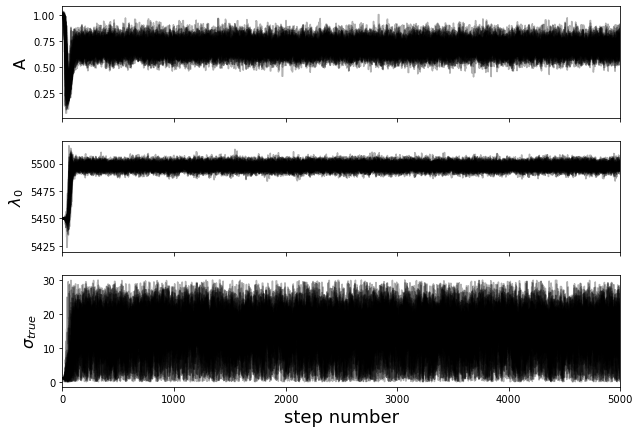

In [15]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "$\lambda_0$", "$\sigma_{true}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontdict={'fontsize':16})
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontdict={'fontsize':18})

### The 'get_autocorr_time()' function is a built-in function in the 'emcee' package and gives the steps for the parameters after which they are pretty much burnt-in.

In [16]:
tau = sampler.get_autocorr_time()
print('\n Burnt-in steps for amplitude : %d' %tau[0])
print('\n Burnt-in steps for central wavelength : %d' %tau[1])
print('\n Burnt-in steps for sigma : %d' %tau[2])


 Burnt-in steps for amplitude : 34

 Burnt-in steps for central wavelength : 63

 Burnt-in steps for sigma : 44


###   2 c)

In [17]:
flat_samples = sampler.get_chain(discard=100, thin=5, flat=True)
print(flat_samples.shape)

(49000, 3)


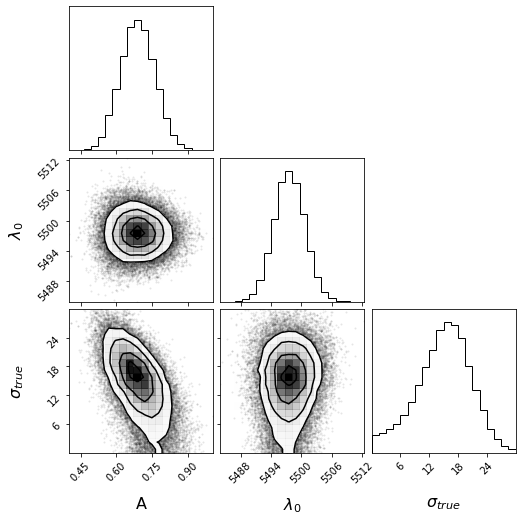

In [18]:
fig = corner.corner(
    flat_samples, labels=labels, label_kwargs ={"fontsize": 16} )

### 2 d) 

In [19]:
sigma_samples = sampler.chain[:, 100:, 2:3].reshape((-1, ndim-2))
sigma_samples.shape

(245000, 1)

In [20]:
up_lim = np.percentile(sigma_samples.T[0], [68.3, 95.4, 99.7])
print("\n 68.3%% upper limit on sigma_true : %f" %up_lim[0])
print("\n 95.4%% upper limit on sigma_true : %f" %up_lim[1])
print("\n 99.7%% upper limit on sigma_true : %f" %up_lim[2])


 68.3% upper limit on sigma_true : 17.804982

 95.4% upper limit on sigma_true : 23.692734

 99.7% upper limit on sigma_true : 28.467906


### 2 e)

### This MCMC method is much more stabble than the method in problem 1. We can start with any initial state  but will end up with similar result with same range of uncertainties.  However this MCMC method is slower than the method in problem 1.

### 3. Reflection

### Problem 3 in HW 8 is such a problem for me. It asked to find the most compact region containing 68.3% of the volume under the posterior surface. However instead of thinking in terms of volume I considered each likelihood as a data point and was trying find out the percentile of these data points. Later I understood that I should have considered the geometric properties of the likelihood surface like how many data points are contained within certain region. This lesson could be applied in my research projects.